## Time series

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from warnings import filterwarnings
filterwarnings('ignore')

In [255]:
data = pd.read_csv('AirPassengers.csv')
data.head(1)

,Month,#Passengers
0,1949-01,112


The data contains a particular month and number of passengers travelling in that month .The data type here is object (month) Let’s convert it into a Time series object and use the Month column as our index.

Timestamps are useful objects for comparisons. You can create a timestamp object with the pd.to_datetime function and a string specifying the date. These timestamps are useful when you need to do logical filtering with dates.

In [256]:
data['Month']= pd.to_datetime(data['Month'],format="%Y-%m")
data.head(1)

,Month,#Passengers
0,1949-01-01,112


In [261]:
data= data.set_index('Month')
ts= data['#Passengers']2

# Problem Statement: 
- The data contains number of passengers travelling in that month. 
- We have historical data of passengers from 1949 till 1960. 
- This is a time series data, our objective is to forecast(predict) data for 10 more years.

### STATIONARITY

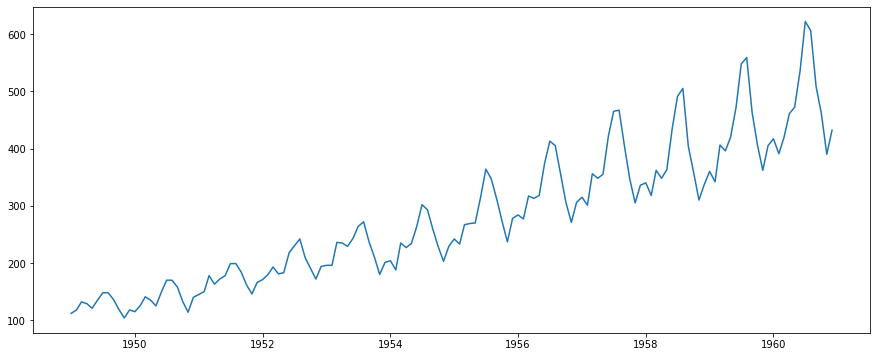

In [262]:
plt.plot(ts);

It’s clear from the plot that there is an overall increase in the trend and with some seasonality in it.

we can assume the series to be stationary if it has constant statistical properties over time and these properties can be:
- constant mean
- constant variance
- an auto co-variance that does not depend on time.

#### Stationarity testing 

In [263]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()


    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

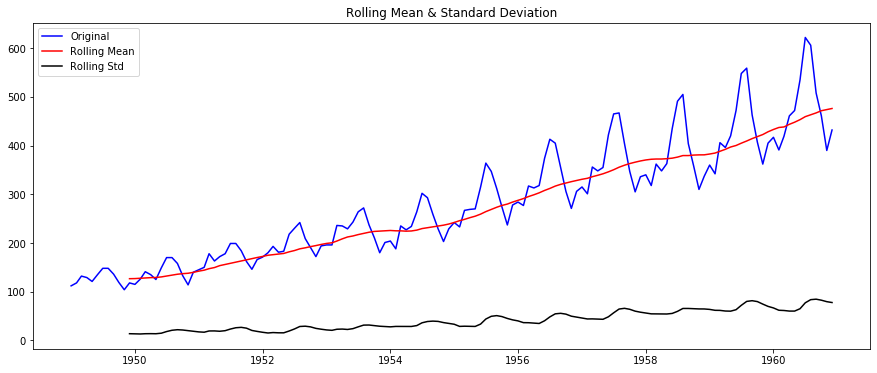

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [264]:
test_stationarity(ts)

This is not stationary because :
- mean is increasing even though the std is small.
- Test stat is > critical value.

There are two major factors that make a time series non-stationary. They are:
- Trend: non-constant mean
- Seasonality: Variation at specific time-frames

### MAKING THE TIME SERIES STATIONARY

The basic idea is to model the trend and seasonality in this series, so we can remove it and make the series stationary. Then we can go ahead and apply statistical forecasting to the stationary series. And finally we can convert the forecasted values into original by applying the trend and seasonality constrains back to those that we previously separated.
Let’s start by working on the trend piece.

#### TREND 

The first step is to reduce the trend using transformation, as we can see here that there is a strong positive trend. These transformation can be log, sq-rt, cube root etc . Basically it penalizes larger values more than the smaller. In this case we will use the logarithmic transformation.

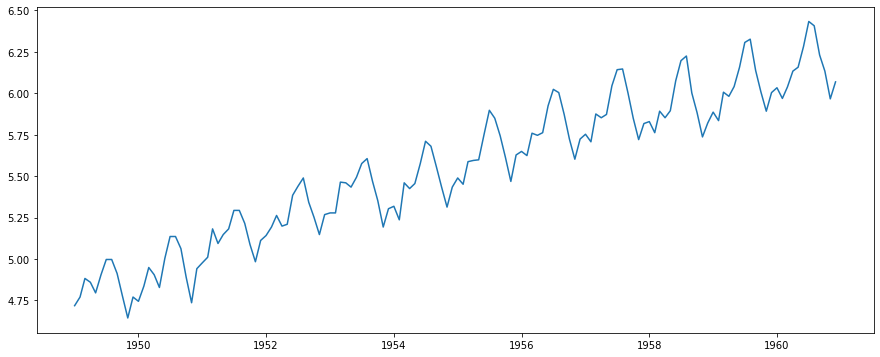

In [265]:
ts_log = np.log(ts)
plt.plot(ts_log)

##### Smoothing 

In smoothing we usually take the past few instances (rolling estimates) .We will discuss two methods under smoothing
- Moving average  
- Exponentially weighted moving average.

###### Moving average

First take x consecutive values and this depends on the frequency if it is 1 year we take 12 values.

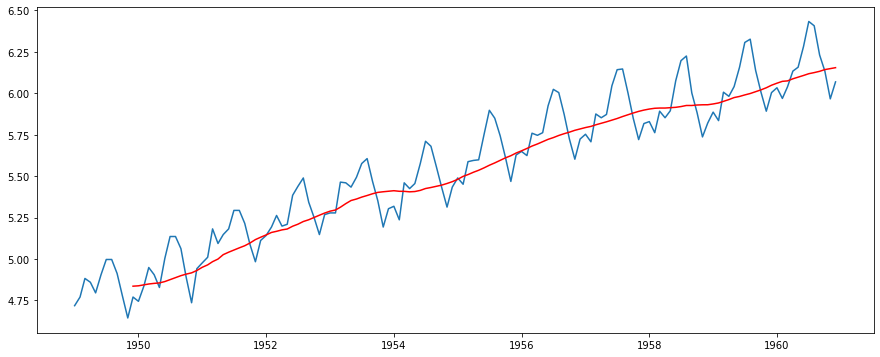

In [266]:
moving_avg=ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red');

In [267]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

The reason there are null values is because we take the average of first 12 so 11 values are null. We can also see that in the visual representation. Thus it is dropped for further analysis. Now let’s parse it to the function to check for stationarity.


In [268]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: #Passengers, dtype: float64

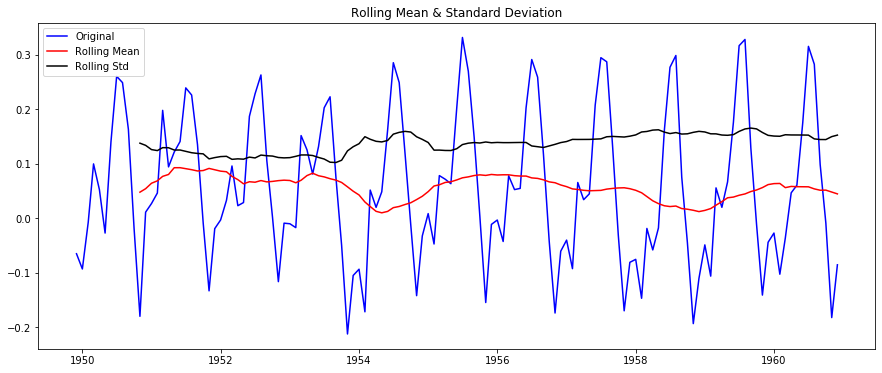

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [269]:
test_stationarity(ts_log_moving_avg_diff)

We notice two things:
- The rolling values are varying slightly but there is no specific trend.
- The test statistics is smaller than the 5 % critical values. That tells us that we are 95% confident that this series is stationary.

###### Exponentially weighted moving average

In this example we can easily take a time period (12 months for a year), but there are situations where the time period range is more complex like stock price etc. So we use the exponentially weighted moving average . The previous values are assigned with a decay factor.

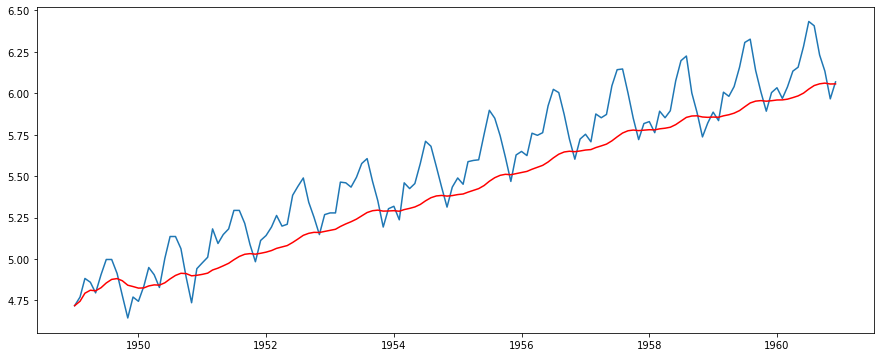

In [270]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

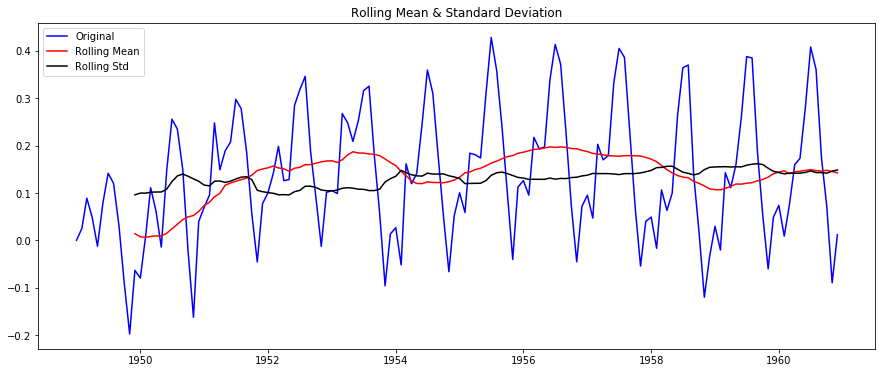

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [271]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

It is stationary because:
- Rolling values have less variations in mean and standard deviation in magnitude.
- the test statistic is smaller than 1% of the critical value. So we can say we are almost 99% confident that this is stationary.

#### SEASONALITY (ALONG WITH TREND) 

Previously we saw just trend part of the time series, now we will see both trend and seasonality. Most Time series have trends along with seasonality. There are two common methods to remove trend and seasonality, they are:
- Differencing: by taking difference using time lag
- Decomposition: model both trend and seasonality, then remove them

##### Differencing:
Here we first take the difference of the value at a particular time with that of the previous time. 

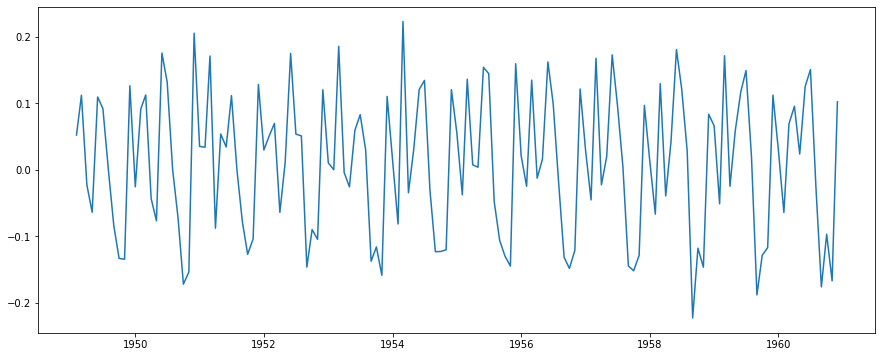

In [272]:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff);

In [273]:
ts_log_diff.isnull().sum()

1

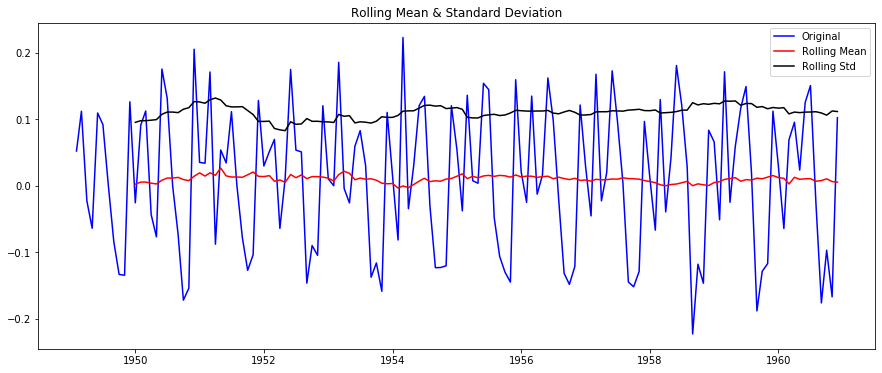

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [274]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

It is stationary because:
- the mean and std variations have small variations with time.
- test statistic is less than 10% of the critical values, so we can be 90 % confident that this is stationary.

# Definitions

- Level: is the average value in the series.
- Trend: is the increasing or decreasing value in the series.
- Seasonality: is the repeating the short-term cycle in the series.
- Noise: is the random variation in the series.

## Types of Model

There are basically two methods to analyze the seasonality of a Time Series: additive and multiplicative.

### The Additive Model
Synthetically it is a model of data in which the effects of the individual factors are differentiated and added to model the data. It can be represented by:
 <br>
 
 **y(t) = Level + Trend + Seasonality + Noise**
 
In the additive model, the behavior is linear where changes over time are consistently made by the same amount, like a linear trend. In this situation, the linear seasonality has the same amplitude and frequency.
<br>

### The Multiplicative Model
In this situation, trend and seasonal components are multiplied and then added to the error component. It is not linear, can be exponential or quadratic and represented by a curved line as below:
<br>

**y(t) = Level * Trend * Seasonality * Noise**

Different from the additive model, the multiplicative model has an increasing or decreasing amplitude and/or frequency over time.

##### Decomposing:
Here we model both the trend and the seasonality, then the remaining part of the time series is returned.

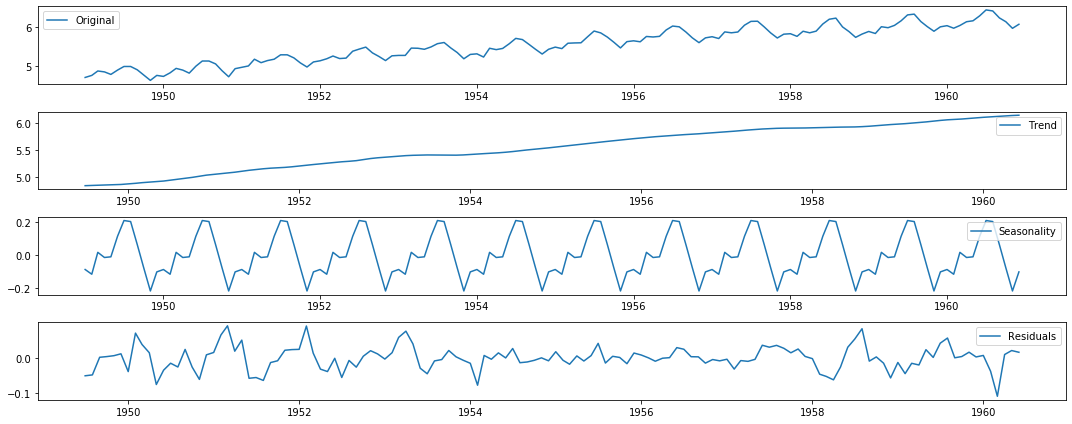

In [275]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Remove the trend and seasonality from the Time series and now we can use the residual values. Let’s check stationarity.

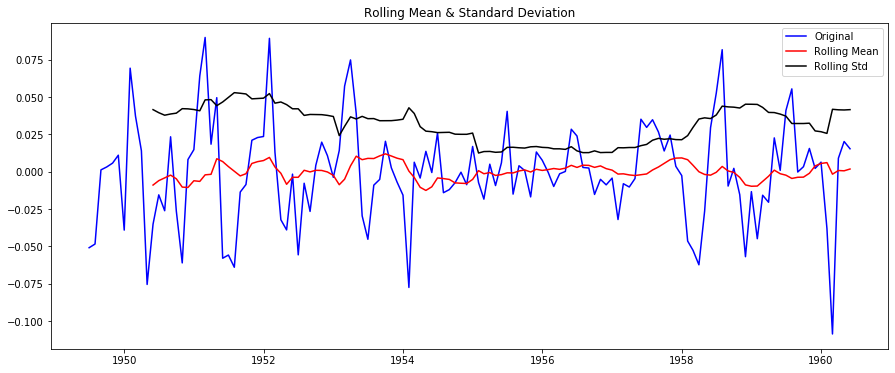

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [276]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

This is stationary because:
- test statistic is lower than 1% critical values.
- the mean and std variations have small variations with time.

### FORECASTING A TIME SERIES 

Now that we have made the Time series stationary, let’s make models on the time series using differencing because it is easy to add the error , trend and seasonality back into predicted values .
We will use statistical modelling method called ARIMA to forecast the data where there are dependencies in the values.
Auto Regressive Integrated Moving Average(ARIMA) — It is like a liner regression equation where the predictors depend on parameters (p,d,q) of the ARIMA model .
Let me explain these dependent parameters:
- p : This is the number of AR (Auto-Regressive) terms . Example — if p is 3 the predictor for y(t) will be y(t-1),y(t-2),y(t-3).
- q : This is the number of MA (Moving-Average) terms . Example — if q is 3 the predictor for y(t) will be e(t-1),e(t-2),e(t-3).
- d :This is the number of differences or the number of non-seasonal differences .

Now let’s check out on how we can figure out what value of p and q to use. We use two popular plotting techniques; they are:
- Autocorrelation Function (ACF): It just measures the correlation between two consecutive (lagged version). example at lag 4, ACF will compare series at time instance t1…t2 with series at instance t1–4…t2–4
- Partial Autocorrelation Function (PACF): is used to measure the degree of association between y(t) and y(t-p).

#### ACF & PACF  

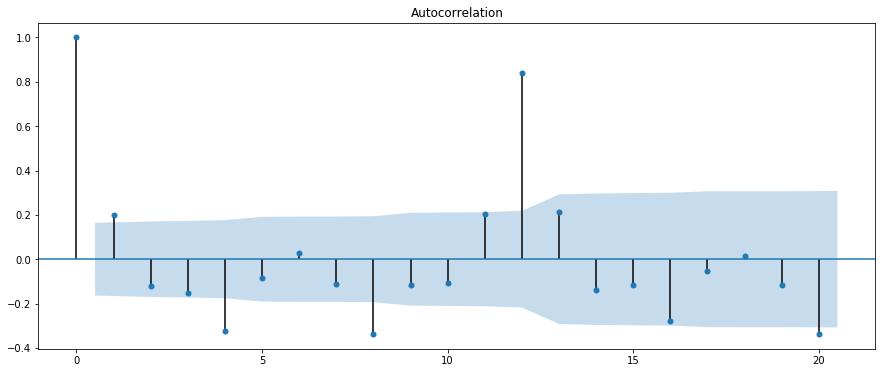

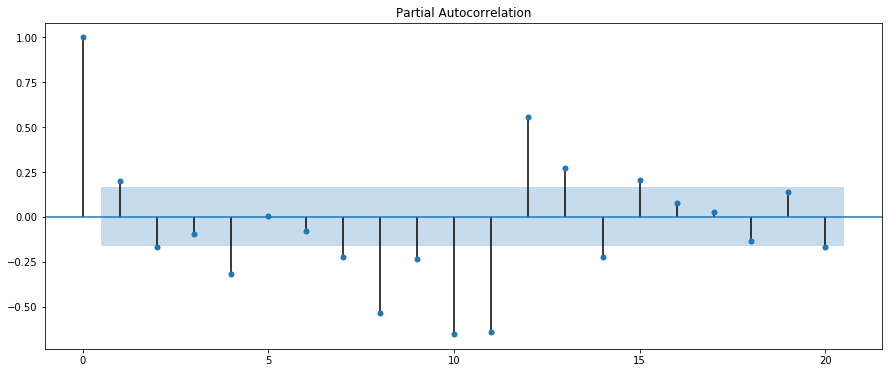

In [277]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log_diff, lags =20)
plot_pacf(ts_log_diff, lags =20)

plt.show()

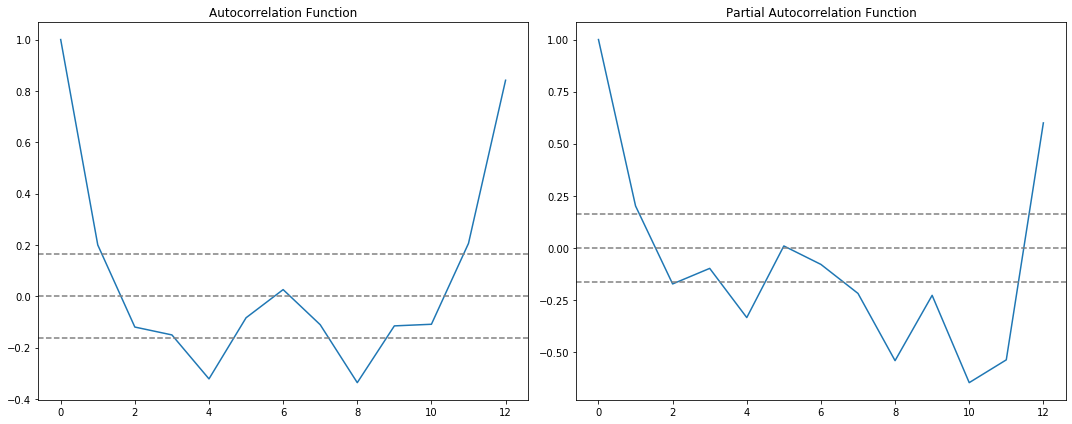

In [278]:
from statsmodels.tsa.arima_model import ARIMA

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=12)
lag_pacf = pacf(ts_log_diff, nlags=12, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The two dotted lines on either sides of 0 are the confidence intervals. These can be used to determine the ‘p’ and ‘q’ values as:
- p: The first time where the PACF crosses the upper confidence interval, here its close to 2. hence p = 2.
- q: The first time where the ACF crosses the upper confidence interval, here its close to 2. hence p = 2.
Now, using this make 3 different ARIMA models considering individual as well as combined effects. I will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.


### AR Model

C:\Users\ashish\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ashish\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


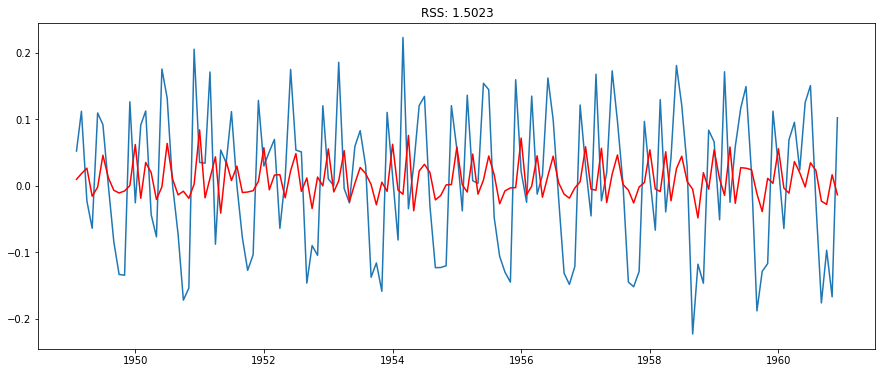

In [279]:
model= ARIMA(ts_log, order=(2,1,0))
results_ar=model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ar.fittedvalues,color='red')
plt.title("RSS: %.4f"%sum((results_ar.fittedvalues-ts_log_diff)**2));

### MA Model

C:\Users\ashish\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ashish\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


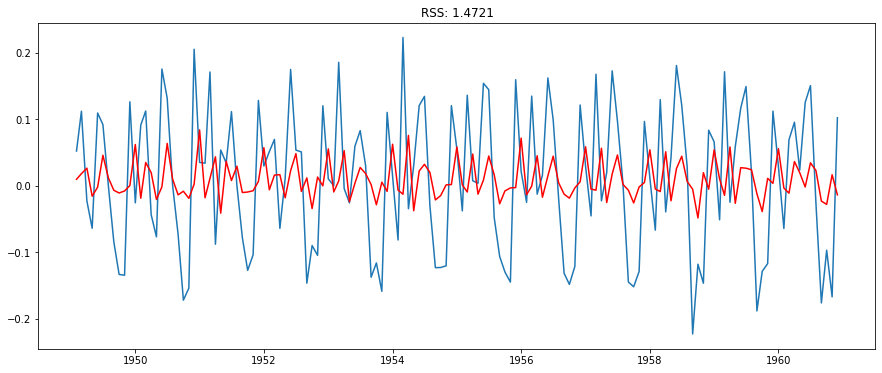

In [280]:
model= ARIMA(ts_log, order=(0,1,2))
results_ma=model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ar.fittedvalues,color='red')
plt.title("RSS: %.4f"%sum((results_ma.fittedvalues-ts_log_diff)**2));

### ARIMA Model

C:\Users\ashish\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\ashish\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


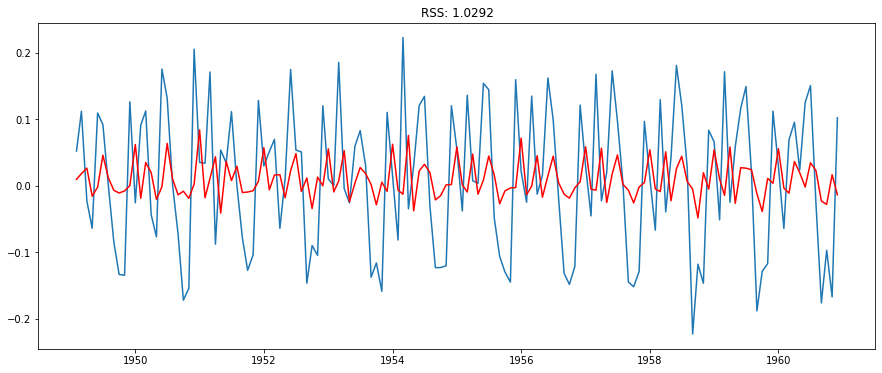

In [281]:
model= ARIMA(ts_log, order=(2,1,2))
results_arima=model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ar.fittedvalues,color='red')
plt.title("RSS: %.4f"%sum((results_arima.fittedvalues-ts_log_diff)**2));

RSS values:
- AR=1.5023
- MA=1.472
- ARIMA =1.0292
- ARIMA has the best RSS values.

#### FINAL STEP: BRINGING THIS BACK TO THE ORIGINAL SCALE
Steps involved:
- First get the predicted values and store it as series. You will notice the first month is missing because we took a lag of 1(shift).
- Now convert differencing to log scale: find the cumulative sum and add it to a new series with a base value (here the first-month value of the log series).

In [282]:
prediction_arima_diff= pd.Series(results_arima.fittedvalues,copy=True)
prediction_arima_diff

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
                ...   
1960-08-01   -0.041176
1960-09-01   -0.092350
1960-10-01   -0.094013
1960-11-01   -0.069924
1960-12-01   -0.008127
Length: 143, dtype: float64

In [283]:
prediction_arima_diff_cumsum= prediction_arima_diff.cumsum()
prediction_arima_diff_cumsum

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372552
1960-09-01    1.280203
1960-10-01    1.186189
1960-11-01    1.116266
1960-12-01    1.108139
Length: 143, dtype: float64

In [284]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0],index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(prediction_arima_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

#### Next Steps 
- take the exponent of the series from above (anti-log) which will be the predicted value — the time series forecast model.
- Now plot the predicted values with the original and Find the RMSE

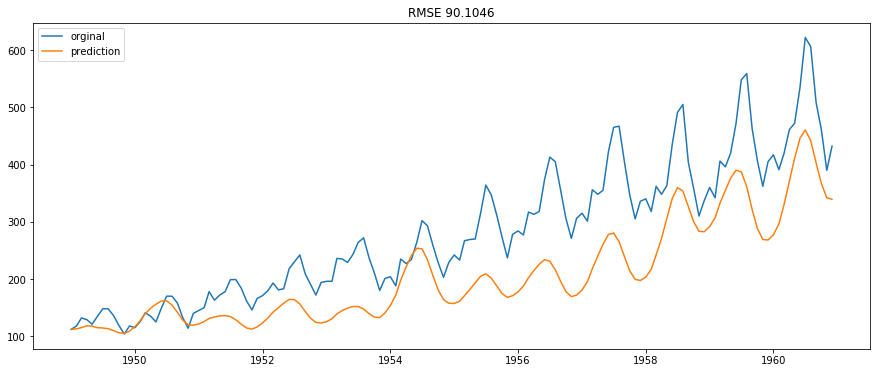

In [285]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts,label="orginal")
plt.plot(predictions_ARIMA,label="prediction")
plt.title("RMSE %.4f"% np.sqrt(sum((predictions_ARIMA-ts)**2/len(ts))))
plt.legend();

We see that our predicted forecasts are very close to the real time series values indicating a fairly accurate model.

### Forcasting for 10 years

- We have 144(existing data of 12 yrs in months) data points. 
- And we want to forecast for additional 120 data points or 10 yrs.

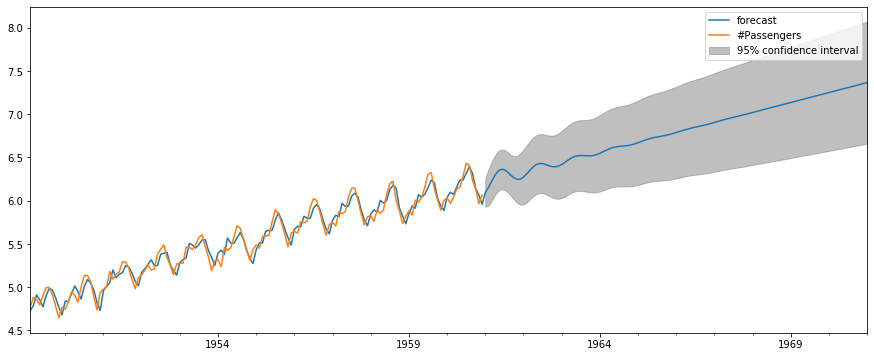

In [286]:
results_arima.plot_predict(1,264);